<a href="https://colab.research.google.com/github/lustraka/Data_Analysis_Workouts/blob/main/Communicate_Data_Findings/Part_I_exploration_scanner_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I - Retail Store Sales Transactions
## by Lubomir STraka

## Introduction
> Introduce the dataset

The Kaggle's anonymized dataset [Retail Store Sales Transactions (Scanner Data)](https://www.kaggle.com/marian447/retail-store-sales-transactions) includes 64.682 transactions of 5.242 SKU's sold to 22.625 customers during one year. Marian Svatko, a Kaggle expert, uploaded detailed data on sales of consumer goods obtained by 'scanning' the bar codes for individual products at electronic points of sale in a retail store. The data provide detailed information about quantities, characteristics and values of goods sold as well as prices.

>**Rubric Tip**: Your code should not generate any errors, and should use functions, loops where possible to reduce repetitive code. Prefer to use functions to reuse code statements.

> **Rubric Tip**: Document your approach and findings in markdown cells. Use comments and docstrings in code cells to document the code functionality.

>**Rubric Tip**: Markup cells should have headers and text that organize your thoughts, findings, and what you plan on investigating next.  



## Preliminary Wrangling


In [6]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

> Load in your dataset and describe its properties through the questions below. Try and motivate your exploration goals through this section.


In [2]:
path = 'https://github.com/lustraka/Data_Analysis_Workouts/blob/main/Communicate_Data_Findings/scanner_data.csv?raw=true'
retail = pd.read_csv(path, index_col=0, parse_dates=['Date'])
retail['Unit_Price'] = retail.Sales_Amount / retail.Quantity
# Check missing values
assert retail.isna().any().any() == False

### What is the structure of your dataset?

Dataset description:
- Int64Index: 131706 entries, 1 to 131706
- Data columns (total 7+1 columns):

| # | Variable | Non-Null | Nunique | Dtype | Notes |
|---|----------|---------:|--------:|:-----|-------|
| 0 | Date | 131706 | 363 | datetime64[ns] | From 2016-01-02 to 2016-12-31 |
| 1 | Customer_ID | 131706 | 22625 | int64 | |
| 2 | Transaction_ID | 131706 | 64682 | int64 | |
| 3 | SKU_Category | 131706 | 187 | object | |
| 4 | SKU | 131706 | 5242 | object | |
| 5 | Quantity | 131706 | 83 | float64 | |
| 6 | Sales_Amount | 131706 | 3233 | float64 | Unit price times quantity. |
| 7 | Unit_Price | 131706 | 4316 | float64 | Unit_price = Sales_Amount / Quantity |

- dtypes: datetime64(1), float64(3), int64(2), object(2)
- memory usage: 9.0+ MB

Source:
```python
# #, Variable, Non-Null (Count), Dtype:
retail.info()
# Nunique:
retail.nunique()
# Check date
retail.Date.min(), retail.Date.max()
```

### What is/are the main feature(s) of interest in your dataset?

- Sales over time
- Product categories
- Customers and their purchasing patterns

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

- Date
- Customer_ID
- SKU_Category
- Sales_Amount
- Unit_Price

The dataset contains individual transactions, therefore we will need also some aggregations.

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.


> **Rubric Tip**: The project (Parts I alone) should have at least 15 visualizations distributed over univariate, bivariate, and multivariate plots to explore many relationships in the data set.  Use reasoning to justify the flow of the exploration.



>**Rubric Tip**: Use the "Question-Visualization-Observations" framework  throughout the exploration. This framework involves **asking a question from the data, creating a visualization to find answers, and then recording observations after each visualisation.** 


In [3]:
# Show statistics of numerical variables
retail.describe()

,Customer_ID,Transaction_ID,Quantity,Sales_Amount,Unit_Price
count,131706.000000,131706.000000,131706.000000,131706.000000,131706.000000
mean,12386.450367,32389.604187,1.485311,11.981524,9.692429
std,6086.447552,18709.901238,3.872667,19.359699,14.944890
min,1.000000,1.000000,0.010000,0.020000,0.015000
25%,7349.000000,16134.000000,1.000000,4.230000,3.680000
50%,13496.000000,32620.000000,1.000000,6.920000,6.070000
75%,17306.000000,48548.000000,1.000000,12.330000,10.100000
max,22625.000000,64682.000000,400.000000,707.730000,693.800000




>**Rubric Tip**: Visualizations should depict the data appropriately so that the plots are easily interpretable. You should choose an appropriate plot type, data encodings, and formatting as needed. The formatting may include setting/adding the title, labels, legend, and comments. Also, do not overplot or incorrectly plot ordinal data.

In [31]:
# Define a function
def plot_top_rel_freq(data, title, top=None, nobs=None):
  """Plot `top` values the `data` series.
  
  Args:
     data - a pd.Series with counts to plot
     title - a chart's title ({} displays a number of categories)
     top - if None, plot all categories
     nobs - if None, use `data.sum()`"""
  
  def set_step(step):
    """Set nicely rounded step size."""
    lg = -1*np.log10(step)
    if lg > 0.1:
      if round(step, round(lg)) < 0.001:
        return 0.001
      else:
        return round(step, round(lg))
    else:
      return round(step, -1)
  
  # Choose the first tuple of RGB colors to reduce distraction
  base_color = sns.color_palette()[0]

  # Check the order of values
  data = data.sort_values(ascending=False)

  # If top == None, plot all observations.
  if top == None or top > data.shape[0]:
    top = data.shape[0]
  
  # If nobs == None, use data.sum()
  if nobs == None:
    nobs = data.sum()
  
  # Compute the lenght of the longest bar in terms of proportion
  max_prop = data.iloc[0] / nobs
  # Produce a set of evenly spaced proportioned values
  tick_props = np.arange(0, max_prop, set_step(max_prop/5))
  # Create tick labels
  tick_names = [f'{v:.1%}' for v in tick_props]

  fig, ax = plt.subplots(figsize=(6.4, 4.8))
  ax = sns.barplot(x=data[:top].values, y=data[:top].index, color=base_color)
  # Change tick locations and labels
  plt.xticks(tick_props * nobs, tick_names)

  # Print the proportion text on the bars
  if max_prop > 0.005:
    for i in range(top):
        # Read count
        count = data.iloc[i]
        # Convert count into a percentage, and then into string
        pct_count = f'{count/nobs:.1%}'
        # Print the string value on the bar
        plt.text(count+round(data[0]/100), i, pct_count, va='center')
    left, right = plt.xlim()
    plt.xlim(left, right+round(data[0]/15))

  # Render the chart
  ax.set_title(title.format(top))

  return None


**Product (SKU) Categories**

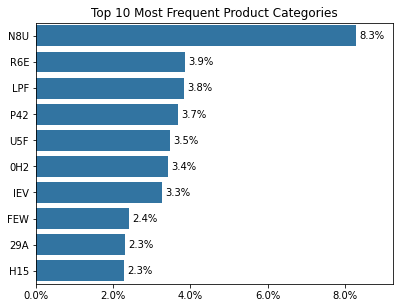

In [37]:
plot_top_rel_freq(retail.SKU_Category.value_counts(), 'Top {} Most Frequent Product Categories', 10)

Out of 187 product categories, top 5 regarding frequency of occurence in transactions are N8U, R6E, LPF, P42, and U5F. The proportion of N8U category is 8.3%, the poportions of the R6E to U5F are between 3.9 to 3.5%. The figure above show top 5 most frequent product categories.

**Product (SKU)**

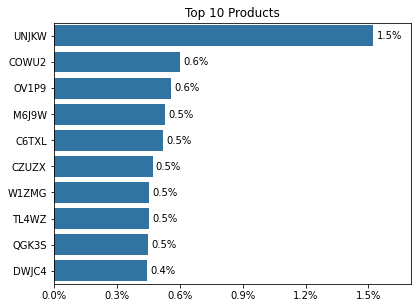

In [33]:
plot_top_rel_freq(retail.SKU.value_counts(), 'Top {} Most Frequent Products', 10)

Out of 5242 products, the 5 most frequent products are UNJKW (1.5%), COWU2 (0.6%), OV1P9 (0.6%), M6J9W (0.5%), and C6TXL (0.5%)

**Customers**

In [38]:
# Check the maximum proportion of customer counts
data = retail.Customer_ID.value_counts()
data.iloc[:5]/data.sum()

1660     0.001731
1665     0.001686
17104    0.001655
1685     0.001450
16905    0.001359
Name: Customer_ID, dtype: float64

Out of 22625 customer, the 5 most frequent customer IDs are 1660 (0.173%), 1665 (0.168%), 17104 (0.166%), 1675  (0.145%), and 16905 (0.136%).

These proportions are too little for visualization with current version of `plot_top_rel_freq()` method:

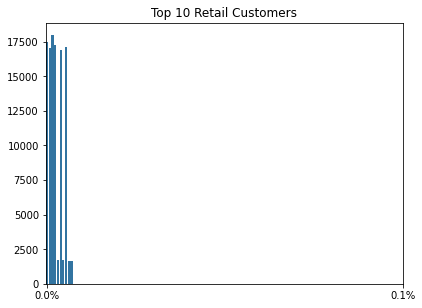

In [35]:
plot_top_rel_freq(retail.Customer_ID.value_counts(), 'Top {} Retail Customers', 10)

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

In [ ]:
# Analyze Average Sales
average_sales = retail.groupby('Date')['Sales_Amount'].mean().to_frame()
average_sales.head()

,Sales_Amount
Date,
2016-01-02,11.276519
2016-01-03,12.289252
2016-01-04,10.420989
2016-01-05,8.459050
2016-01-06,13.231226


In [ ]:
average_sales['Time'] = np.arange(average_sales.shape[0])
lm = smf.ols('Sales_Amount ~ Time', data=average_sales).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:           Sales_Amount   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.035
Date:                Thu, 21 Oct 2021   Prob (F-statistic):              0.155
Time:                        12:48:34   Log-Likelihood:                -718.30
No. Observations:                 363   AIC:                             1441.
Df Residuals:                     361   BIC:                             1448.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.3983      0.184     61.989      0.0

The linear regression model has an intercept 11.3983 and coefficients [0.0013].



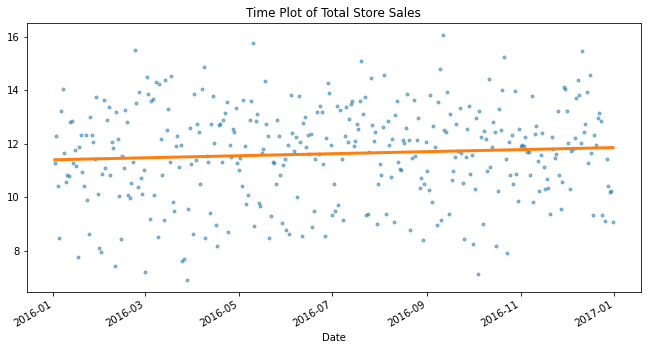

In [ ]:
# Visualize regression of average sales onto time
X = average_sales.loc[:,['Time']]
y = average_sales['Sales_Amount']
# Train the model
model = LinearRegression()
model.fit(X, y)
# Estimate target
y_hat = pd.Series(model.predict(X), X.index)

# Plot actual and estimated response
fig, ax = plt.subplots(figsize=(11, 5.5))
y.plot(style='.', alpha=0.5)
y_hat.plot(lw=3)
ax.set_title(f'Time Plot of Total Store Sales');

print(f'The linear regression model has an intercept {model.intercept_:.4f} and coefficients {model.coef_.round(4)}.\n')

In [ ]:
# Visualize regression of average sales onto sales in the previous day
# Create a lag feature
average_sales['Lag_1'] = average_sales.Sales_Amount.shift(1)
# Regress average sales on the lag feature

lm = smf.ols('Sales_Amount ~ Lag_1', data=average_sales.dropna()).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:           Sales_Amount   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.138
Date:                Thu, 21 Oct 2021   Prob (F-statistic):              0.287
Time:                        12:48:34   Log-Likelihood:                -717.25
No. Observations:                 362   AIC:                             1439.
Df Residuals:                     360   BIC:                             1446.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9713      0.621     17.672      0.0

The linear regression model has an intercept 10.9713 and coefficients [0.0563].



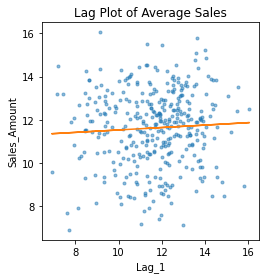

In [ ]:
# Prepare training data
X = average_sales.loc[:,['Lag_1']].dropna()
y = average_sales['Sales_Amount']
y, X = y.align(X, join='inner') # Drop corresponding values in target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Estimate target
y_hat = pd.Series(model.predict(X), X.index)

# Plot actual and predicted variables
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', alpha=0.5)
ax.plot(X['Lag_1'], y_hat)
ax.set(aspect='equal', ylabel='Sales_Amount', xlabel='Lag_1', title='Lag Plot of Average Sales');

print(f'The linear regression model has an intercept {model.intercept_:.4f} and coefficients {model.coef_.round(4)}.\n')

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

## Conclusions
>You can write a summary of the main findings and reflect on the steps taken during the data exploration.



> Remove all Tips mentioned above, before you convert this notebook to PDF/HTML


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML or PDF` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

